In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn import set_config
set_config(display='diagram')

from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA

In [4]:
import importlib
importlib.reload(ctf)
importlib.reload(utils)

NameError: name 'ctf' is not defined

In [5]:
import custom_transformers as ctf
from custom_transformers import *

import utils as utils
from utils import *

## Load Data

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

## Missing Value Analysis

In [7]:
np.round(100*train_data.isna().sum()/train_data.shape[0],1).sort_values(ascending=False)

belongs_to_collection    79.9
homepage                 68.5
tagline                  19.9
Keywords                  9.2
production_companies      5.2
production_countries      1.8
spoken_languages          0.7
crew                      0.5
cast                      0.4
overview                  0.3
genres                    0.2
runtime                   0.1
title                     0.0
status                    0.0
id                        0.0
release_date              0.0
poster_path               0.0
popularity                0.0
original_title            0.0
original_language         0.0
imdb_id                   0.0
budget                    0.0
revenue                   0.0
dtype: float64

## Features

- id: no relation to revenue
- belongs_to_collection: useful for sequels, prequels, remakes. but how to encode it?
    - use collection_id with OHE, if null set it to 'original'
- budget: use as it is / log transform?; numerical; used in base estimator
- genres: use id, how to encode multivalue attributes?
    - create as many columns as there are unique ids, if a movie belongs to a genre, its column is set to 1
    - what happens during test time? - unseen genre? - ignore it
    - quickly increases the feature space dimensionality - use dimensionality reduction?
        - use dimensionality reduction on just genres or on all features?
        - there is not much correlation between genres, dimensionality reduction isn't effective - prove this
- homepage: has homepage or not?
- imdb_id: not relevant - see if any null? if it doesn't have an IMDB page, not a very popular movie
- original_language - OHE
- original_title - how to encode text? n - grams? - embedding?
- overview - how to encode text?
- popularity: numerical; used in base estimator
- poster_path: how to use images?
- production_companies: use the same approach as genres
- production_countries: use the same approach as genres
- release date: split into date, month, year; numerical; used in base estimator
- runtime: numerical; used in base estimator
- spoken_languages: use the same approach as genres
- status: OHE
- tagline: how to encode text
    - presence
- title: how to encode text
- keywords: use the same approach as genres
- cast:
    - number of members
    - number by gender
    - presence of a cast member (same approach as genre) - multinomial attribute
    - presence of a character (same approach as genre) - multinomial attribute
- crew:
    - number of members
    - number by gender
    - presence of a crew member (same approach as genre) - multinomial attribute
    - presence of a role (same approach as genre) - multinomial attribute
    - number of people in a department
- revenue: log transform; used in base estimator

### Features to One Hot Encode
- No transformation
    - original_language
    - status
- Needs Transformation (presence Y/N)
    - homepage
    - tagline

### Counts (of multinomial attributes)
- genres
- cast
- crew
- keywords
- spoken_languages
- production_countries
- production_companies



### Multinomial Name Extraction:
- genres
- keywords
- spoken_languages
- production_countries
- production_companies

### Custom Features
- belongs_to_collection
- Cast
- Crew

### Text Analysis
- original_title
- overview
- tagline (only presence was used)
- title

### Discarded Features
- id
- imdb_id
- poster_path


## Data Exploration

In [8]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

### Keywords

In [43]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['Keywords']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

woman_director          175.0
independent_film        155.0
duringcreditsstinger    134.0
murder                  123.0
based_on_novel          111.0
violence                 87.0
sport                    82.0
biography                77.0
aftercreditsstinger      75.0
dystopia                 73.0
revenge                  73.0
friendship               72.0
sex                      71.0
suspense                 67.0
sequel                   66.0
police                   64.0
love                     64.0
teenager                 61.0
nudity                   57.0
female_nudity            53.0
drug                     52.0
prison                   50.0
high_school              49.0
musical                  49.0
los_angeles              48.0
dtype: float64

In [44]:
tf_df.shape

(3000, 7400)

In [47]:
np.sum(tf_df.var() > 0.01)

52

In [57]:
p=0.01010205
p*(1-p)

0.0099999985857975

In [50]:
def quad_root(a,b,c):
    t = np.sqrt(b**2-4*a*c)
    return (-b-t)/(2*a), (-b+t)/(2*a)
quad_root(1, -1, 0.01)

(0.010102051443364402, 0.9898979485566356)

In [63]:
pca = PCA(n_components=1000)

tf2 = pca.fit_transform(tf_df)

In [69]:
np.sum(np.var(tf2, axis=0)>0.01)

124

### spoken_languages

In [11]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['spoken_languages']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

English      2618.0
Français      288.0
Español       239.0
Deutsch       169.0
Pусский       152.0
Italiano      124.0
日本語            89.0
普通话            68.0
हिन्दी         56.0
               43.0
Português      43.0
العربية        40.0
한국어/조선말        37.0
广州话_/_廣州話      36.0
தமிழ்          27.0
Polski         25.0
Magyar         24.0
Latin          23.0
svenska        22.0
ภาษาไทย        22.0
Český          20.0
עִבְרִית       15.0
ελληνικά       15.0
Dansk          13.0
Türkçe         13.0
dtype: float64

In [12]:
tf_df.shape

(3000, 56)

### production_countries

In [13]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['production_countries']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

United_States_of_America    2282.0
United_Kingdom               380.0
France                       222.0
Germany                      167.0
Canada                       120.0
India                         81.0
Italy                         64.0
Australia                     61.0
Japan                         61.0
Russia                        58.0
Spain                         54.0
Hong_Kong                     42.0
China                         42.0
Belgium                       23.0
Ireland                       23.0
South_Korea                   22.0
Mexico                        19.0
Sweden                        18.0
New_Zealand                   17.0
Netherlands                   15.0
Czech_Republic                14.0
Denmark                       13.0
Brazil                        12.0
South_Africa                  10.0
Luxembourg                    10.0
dtype: float64

In [14]:
tf_df.shape

(3000, 74)

### production_companies

In [15]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['production_companies']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

Warner_Bros.                              202.0
Universal_Pictures                        188.0
Paramount_Pictures                        161.0
Twentieth_Century_Fox_Film_Corporation    138.0
Columbia_Pictures                          91.0
Metro-Goldwyn-Mayer_(MGM)                  84.0
New_Line_Cinema                            75.0
Touchstone_Pictures                        63.0
Walt_Disney_Pictures                       62.0
Columbia_Pictures_Corporation              61.0
TriStar_Pictures                           53.0
Relativity_Media                           48.0
Canal+                                     46.0
United_Artists                             44.0
Miramax_Films                              40.0
Village_Roadshow_Pictures                  36.0
Regency_Enterprises                        31.0
BBC_Films                                  30.0
Dune_Entertainment                         30.0
Working_Title_Films                        30.0
Fox_Searchlight_Pictures                

In [16]:
tf_df.shape

(3000, 3695)

### Cast - names

In [17]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['cast']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

Robert_De_Niro        30.0
Samuel_L._Jackson     30.0
Morgan_Freeman        27.0
Susan_Sarandon        25.0
Bruce_Willis          25.0
Liam_Neeson           25.0
J.K._Simmons          25.0
Bruce_McGill          24.0
John_Turturro         24.0
Forest_Whitaker       23.0
Willem_Dafoe          23.0
Nicolas_Cage          22.0
Bill_Murray           22.0
Owen_Wilson           22.0
Mel_Gibson            21.0
Sigourney_Weaver      21.0
John_Goodman          21.0
Sylvester_Stallone    21.0
Jason_Statham         21.0
Keith_David           21.0
Matt_Damon            20.0
Dennis_Quaid          20.0
Richard_Jenkins       20.0
Ed_Harris             20.0
Michael_Caine         20.0
dtype: float64

In [18]:
tf_df.shape

(3000, 38588)

### cast - gender

In [19]:
class UniqueCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories_ = None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        res =  pd.DataFrame(map(lambda c: dict(zip(*np.unique(c, return_counts=True))), X))
        self.categories_ = list(res.columns)
        return res

In [20]:
pipe = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('gender'),
        # FunctionTransformer(lambda x: pd.DataFrame(list(x.apply(lambda c: dict(zip(*np.unique(c, return_counts=True))))))),
        UniqueCountTransformer(),
        SimpleImputer(strategy='constant', fill_value=0)
    )

x = pipe.fit_transform(X[['cast']])

In [21]:
x.shape

(3000, 3)

In [22]:
pipe.named_steps['uniquecounttransformer'].categories_

[0, 1, 2]

### cast - characters

In [23]:
pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('character'),
        MultinomialAttributeTransformer()
    )
tf = pipeline.fit_transform(X[['cast']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

                  208.0
Himself           162.0
Doctor             77.0
Herself            66.0
Waitress           66.0
Nurse              59.0
Bartender          53.0
Jack               53.0
Paul               48.0
Security_Guard     48.0
Reporter           45.0
Frank              44.0
Charlie            41.0
Priest             40.0
Waiter             39.0
Tony               38.0
David              38.0
Mary               38.0
Sam                37.0
Tommy              37.0
John               36.0
Sarah              36.0
Judge              35.0
Anna               35.0
Cop                35.0
dtype: float64

In [24]:
tf_df.shape

(3000, 44422)

### Crew - names

In [25]:
pipeline = make_name_extraction_pipeline()
tf = pipeline.fit_transform(X[['crew']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

Avy_Kaufman            50.0
Deborah_Aquila         40.0
James_Newton_Howard    39.0
Jerry_Goldsmith        37.0
Mary_Vernieu           37.0
Francine_Maisler       35.0
Tricia_Wood            35.0
James_Horner           33.0
Kerry_Barden           32.0
Steven_Spielberg       31.0
Janet_Hirshenson       30.0
Harvey_Weinstein       30.0
Bob_Weinstein          30.0
Jane_Jenkins           29.0
Hans_Zimmer            28.0
John_Papsidera         28.0
John_Debney            28.0
Billy_Hopkins          27.0
Hans_Bjerno            26.0
Mark_Isham             26.0
Danny_Elfman           26.0
Mindy_Marin            26.0
Neal_H._Moritz         26.0
Tim_Bevan              26.0
Sarah_Finn             25.0
dtype: float64

In [26]:
tf_df.shape

(3000, 38554)

### crew - job

In [70]:
pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('job'),
        MultinomialAttributeTransformer()
    )
tf = pipeline.fit_transform(X[['crew']])
columns = pipeline.named_steps['multinomialattributetransformer'].categories_
tf_df = pd.DataFrame(tf, columns=columns)
tf_df.sum().sort_values(ascending=False).iloc[:25]

Director                    2984.0
Producer                    2373.0
Editor                      2195.0
Director_of_Photography     2177.0
Screenplay                  1797.0
Original_Music_Composer     1732.0
Production_Design           1582.0
Casting                     1504.0
Costume_Design              1449.0
Executive_Producer          1318.0
Art_Direction               1242.0
Set_Decoration              1154.0
Writer                      1029.0
Script_Supervisor            781.0
Makeup_Artist                650.0
Still_Photographer           622.0
Music                        541.0
Music_Editor                 533.0
Stunt_Coordinator            521.0
Supervising_Sound_Editor     503.0
Sound_Re-Recording_Mixer     499.0
Camera_Operator              487.0
Hairstylist                  484.0
Costume_Supervisor           463.0
Novel                        443.0
dtype: float64

In [28]:
tf_df.shape

(3000, 412)

### crew - gender

In [29]:
pipe = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('gender'),
        # FunctionTransformer(lambda x: pd.DataFrame(list(x.apply(lambda c: dict(zip(*np.unique(c, return_counts=True))))))),
        UniqueCountTransformer(),
        SimpleImputer(strategy='constant', fill_value=0)
    )

x = pipe.fit_transform(X[['crew']])

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

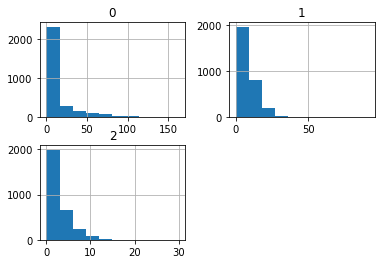

In [30]:
pd.DataFrame(x, columns=[0,1,2]).hist()

### crew - department

In [31]:
pipe = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('department'),
        # FunctionTransformer(lambda x: pd.DataFrame(list(x.apply(lambda c: dict(zip(*np.unique(c, return_counts=True))))))),
        UniqueCountTransformer(),
        SimpleImputer(strategy='constant', fill_value=0)
    )

x = pipe.fit_transform(X[['crew']])

In [32]:
x.shape

(3000, 12)

In [33]:
pipe.named_steps['uniquecounttransformer'].categories_

['Art',
 'Camera',
 'Costume & Make-Up',
 'Crew',
 'Directing',
 'Editing',
 'Lighting',
 'Production',
 'Sound',
 'Visual Effects',
 'Writing',
 'Actors']

array([[<AxesSubplot:title={'center':'Art'}>,
        <AxesSubplot:title={'center':'Camera'}>,
        <AxesSubplot:title={'center':'Costume & Make-Up'}>],
       [<AxesSubplot:title={'center':'Crew'}>,
        <AxesSubplot:title={'center':'Directing'}>,
        <AxesSubplot:title={'center':'Editing'}>],
       [<AxesSubplot:title={'center':'Lighting'}>,
        <AxesSubplot:title={'center':'Production'}>,
        <AxesSubplot:title={'center':'Sound'}>],
       [<AxesSubplot:title={'center':'Visual Effects'}>,
        <AxesSubplot:title={'center':'Writing'}>,
        <AxesSubplot:title={'center':'Actors'}>]], dtype=object)

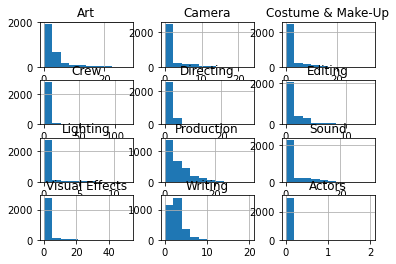

In [34]:
pd.DataFrame(x, columns=pipe.named_steps['uniquecounttransformer'].categories_).hist()

## SelectMostKFrequent

In [35]:
class SelectMostKFrequent(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
        self.k_frequent_ = None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_df = pd.DataFrame(X)
        self.k_frequent_ = list(X_df.sum().sort_values(ascending=False).iloc[:self.k].index)
        
        return X_df.iloc[:, self.k_frequent_]
    
pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer('job'),
        MultinomialAttributeTransformer(),
        SelectMostKFrequent(25)
    )

tf = pipeline.fit_transform(X[['crew']])

In [36]:
columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_

tf.columns = columns[k_frequent]
tf.sum()

Director                    2984.0
Producer                    2373.0
Editor                      2195.0
Director_of_Photography     2177.0
Screenplay                  1797.0
Original_Music_Composer     1732.0
Production_Design           1582.0
Casting                     1504.0
Costume_Design              1449.0
Executive_Producer          1318.0
Art_Direction               1242.0
Set_Decoration              1154.0
Writer                      1029.0
Script_Supervisor            781.0
Makeup_Artist                650.0
Still_Photographer           622.0
Music                        541.0
Music_Editor                 533.0
Stunt_Coordinator            521.0
Supervising_Sound_Editor     503.0
Sound_Re-Recording_Mixer     499.0
Camera_Operator              487.0
Hairstylist                  484.0
Costume_Supervisor           463.0
Novel                        443.0
dtype: float64

## Base Estimator

Conditional Pipelien: Train two models, one on data where a meaningful budget is present, other without the budget feature

In [78]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

def make_mask(X, thresh=500):
    return X['budget'] < thresh

In [86]:
class FeaturePipelines():
    def __init__(self):
        pass
        
    def get_config(self, include_budget=True):
        common_config = [
            ('popularity', make_pipeline(
                SimpleImputer(strategy='median'), 
                StandardScaler()
            ), ['popularity']),

            ('runtime', make_pipeline(
                RuntimeImputer, 
                StandardScaler()
            ), ['runtime']),

            ('release_date', make_pipeline(
                SimpleImputer(strategy='most_frequent'), 
                ReleaseDateTransformer()
            ), ['release_date']), 
            
            ('original_language+status', make_pipeline(
                SimpleImputer(strategy='most_frequent'), 
                OneHotEncoder(handle_unknown='ignore')
            ), ['original_language', 'status']),
            
            ('homepage+tagline', presenceBinarizer
             , ['homepage', 'tagline']),
            
            ('genres_counts', make_attribute_count_pipeline(), ['genres']),
            ('cast_counts', make_attribute_count_pipeline(), ['cast']),
            ('crew_counts', make_attribute_count_pipeline(), ['crew']),
            ('keywords_counts', make_attribute_count_pipeline(), ['Keywords']),
            ('production_companies_counts', make_attribute_count_pipeline(), ['production_companies']),
            ('production_countries_counts', make_attribute_count_pipeline(), ['production_countries']),
            ('spoken_languages_counts', make_attribute_count_pipeline(), ['spoken_languages']),
            
            ('genres', make_name_extraction_pipeline(), ['genres']),
            
            ('cast_gender', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('gender'),
                UniqueCountTransformer(),
                SimpleImputer(strategy='constant', fill_value=0)
            ), ['cast']), 
            
            ('crew_gender', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('gender'),
                UniqueCountTransformer(),
                SimpleImputer(strategy='constant', fill_value=0)
            ), ['crew']),
            
            ('crew_department', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('department'),
                UniqueCountTransformer(),
                SimpleImputer(strategy='constant', fill_value=0)
            ), ['crew']),
            
            ('crew_jobs', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('job'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(25)
            ), ['crew']),
            
             ('crew_names', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                PCA(100)
            ), ['crew']),
            
            ('cast_names', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                PCA(100)
            ), ['cast']),
            
            ('cast_characters', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('character'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                PCA(100)
            ), ['cast']),
            
            ('keywords', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                PCA(100)
            ), ['Keywords']),
            
            ('spoken_languages', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
            ), ['spoken_languages']),
            
            ('production_countries', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
            ), ['production_countries']),
            
            ('production_companies', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                PCA(100)
            ), ['production_companies'])
        ]
        
        budget_config = [
            ('budget', make_pipeline(
                SimpleImputer(strategy='median'),
                FunctionTransformer(np.log1p),
                StandardScaler()
            ), ['budget'])
        ]
        
        return (budget_config if include_budget else []) + common_config
    
    def get_features(self, prep_pipeline, include_budget=True):
        features = ['popularity', 'runtime', 'release_year', 'release_month', 'release_DOW']
        orig_lang, status = prep_pipeline.named_transformers_['original_language+status'].named_steps['onehotencoder'].categories_
        features += list(orig_lang) + list(status)
        features += ['homepage', 'tagline']
        features += ['genres_counts', 'cast_counts', 'crew_counts', 'keywords_counts', 'production_companies_counts', 'production_countries_counts', 'spoken_languages_counts']
        features += prep_pipeline.named_transformers_['genres'].named_steps['multinomialattributetransformer'].categories_
        features += ['cast_gender_'+str(f) for f in prep_pipeline.named_transformers_['cast_gender'].named_steps['uniquecounttransformer'].categories_]
        features += ['crew_gender_'+str(f) for f in prep_pipeline.named_transformers_['crew_gender'].named_steps['uniquecounttransformer'].categories_]
        features += ['crew_dept_'+str(f) for f in prep_pipeline.named_transformers_['crew_department'].named_steps['uniquecounttransformer'].categories_]
        
        pipeline = prep_pipeline.named_transformers_['crew_jobs']
        columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['crew_jobs_'+str(f) for f in columns[k_frequent]]
        features += ['crew_jobs_'+str(f) for f in columns]
        
        pipeline = prep_pipeline.named_transformers_['crew_names']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['crew_names_'+str(f) for f in columns[k_frequent]]
        features += ['crew_names_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        
        pipeline = prep_pipeline.named_transformers_['cast_names']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['cast_names_'+str(f) for f in columns[k_frequent]]
        features += ['cast_names_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        
        pipeline = prep_pipeline.named_transformers_['cast_characters']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['cast_char_'+str(f) for f in columns[k_frequent]]
        features += ['cast_char_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        
        pipeline = prep_pipeline.named_transformers_['keywords']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['kw_'+str(f) for f in columns[k_frequent]]
        features += ['kw_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        
        pipeline = prep_pipeline.named_transformers_['spoken_languages']
        columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['sl_'+str(f) for f in columns[k_frequent]]
        features += ['sl_'+str(f) for f in columns]
        
        pipeline = prep_pipeline.named_transformers_['production_countries']
        columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['prod_countries_'+str(f) for f in columns[k_frequent]]
        features += ['prod_countries_'+str(f) for f in columns]
        
        pipeline = prep_pipeline.named_transformers_['production_companies']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['prod_compnaies_'+str(f) for f in columns[k_frequent]]
        features += ['prod_compnaies_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        
        return (['budget'] if include_budget else []) + features
    

In [87]:
featurePipelines = FeaturePipelines()

prep_pipeline_A = ColumnTransformer(featurePipelines.get_config(include_budget=False), remainder='drop')
prep_pipeline_B = ColumnTransformer(featurePipelines.get_config(), remainder='drop')

full_pipeline_A = Pipeline([('prep_A', prep_pipeline_A), ('model', RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4))])
full_pipeline_B = Pipeline([('prep_B', prep_pipeline_B), ('model', RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4))])

base_pipeline = ConditionalPredictor(full_pipeline_A, full_pipeline_B, make_mask, 50)
base_pipeline.fit(X_train, y_train)

ConditionalPredictor(make_mask=<function make_mask at 0x17ebe2040>,
                     pipelineA=Pipeline(steps=[('prep_A',
                                                ColumnTransformer(transformers=[('popularity',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 ['popularity']),
                                                                                ('runtime',
                                                                                 Pipeline(steps=[('pipeline',
                                                                                                  Pipeline(steps=[('simpleimputer-1',
                                                                                                                   SimpleImp...
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(fill_value='[]',
                                                                                                                strategy='constant')),
                                                                                                 ('extractiontransformer',
                                                                                                  ExtractionTransformer(key='name')),
                                                                                                 ('multinomialattributetransformer',
                                                                                                  MultinomialAttributeTransformer()),
                                                                                                 ('pca',
                                                                                                  PCA(n_components=100))]),
                                                                                 ['production_companies'])])),
                                               ('model',
                                                RandomForestRegressor(max_depth=40,
                                                                      min_samples_leaf=10,
                                                                      n_jobs=4))]),
                     thresh=50)

### Evaluation

In [88]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train MSE",
                               "Train MSE-A",
                               "Train MSE-B",
                               "Valid MSE",
                               "Valid MSE-A",
                               "Valid MSE-B",
                               "Test  MSE",
                               "Test MSE-A",
                               "Test MSE-B",
                              ])

In [89]:
features = featurePipelines.get_features(prep_pipeline_B, include_budget=True)

exp_name = f"RFC_{len(features)}_features"
scores = {}


scores['test'] = base_pipeline.score(y_test, base_pipeline.predict(X_test))
scores['train'] = base_pipeline.score(y_train, base_pipeline.predict(X_train))


expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round([*scores['train'], 0,0,0, *scores['test']], 4)) 
expLog



,exp_name,Train MSE,Train MSE-A,Train MSE-B,Valid MSE,Valid MSE-A,Valid MSE-B,Test MSE,Test MSE-A,Test MSE-B
0,RFC_1092_features,1.5088,2.1596,1.1732,0.0,0.0,0.0,2.1477,2.7241,1.8763


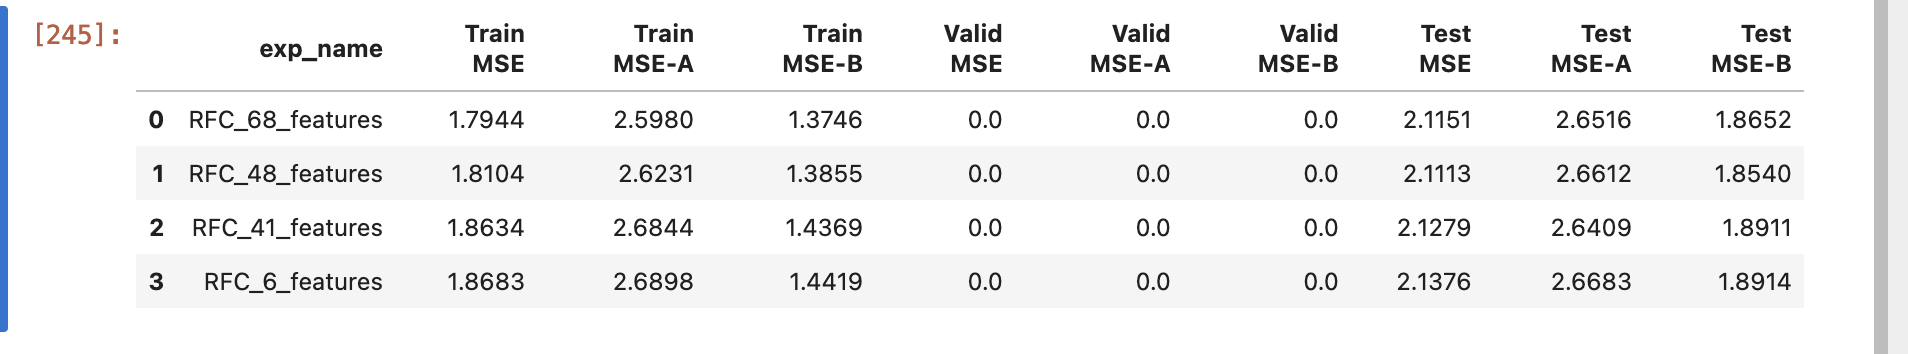

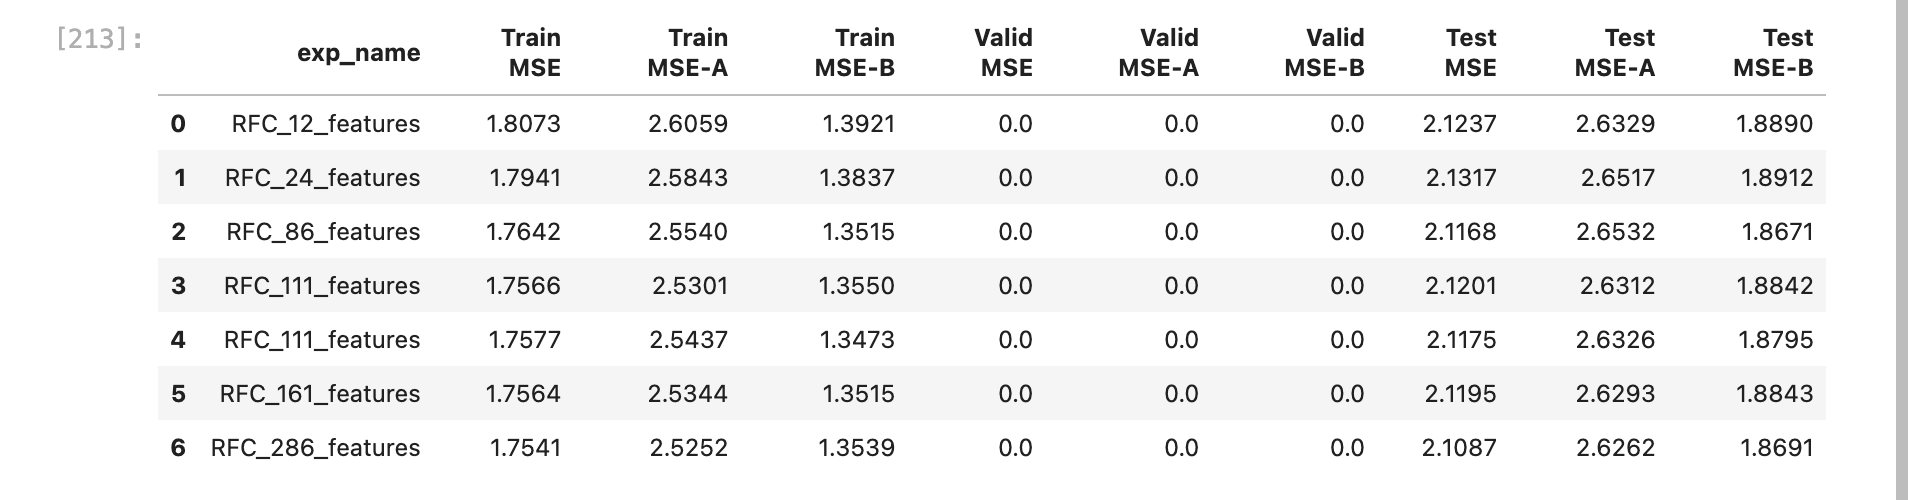

### Feature importance of pipeline without budget

In [90]:
rfr = base_pipeline.pipelineA.named_steps['model']
feat_imp = pd.DataFrame(rfr.feature_importances_.reshape(1, -1), columns=featurePipelines.get_features(prep_pipeline_A, include_budget=False))
feat_imp_sorted = feat_imp.T.sort_values(by=0, ascending=False)
feat_imp_sorted['imp_cumsum'] = feat_imp_sorted.cumsum()
np.round(feat_imp_sorted.iloc[:25],2)

,0,imp_cumsum
popularity,0.14,0.14
prod_compnaies_54,0.07,0.21
release_year,0.04,0.26
cast_names_73,0.02,0.27
prod_compnaies_51,0.01,0.28
cast_char_96,0.01,0.29
prod_compnaies_44,0.01,0.30
cast_char_41,0.01,0.31
prod_compnaies_46,0.01,0.32
cast_gender_2,0.01,0.32


### Feature importance of pipeline with budget

In [91]:
rfr = base_pipeline.pipelineB.named_steps['model']
feat_imp = pd.DataFrame(rfr.feature_importances_.reshape(1, -1), columns=featurePipelines.get_features(prep_pipeline_B, include_budget=True))
feat_imp_sorted = feat_imp.T.sort_values(by=0, ascending=False)
feat_imp_sorted['imp_cumsum'] = feat_imp_sorted.cumsum()
np.round(feat_imp_sorted.iloc[:25], 2)

,0,imp_cumsum
budget,0.48,0.48
popularity,0.13,0.60
prod_compnaies_20,0.01,0.61
prod_compnaies_23,0.01,0.62
cast_names_99,0.01,0.63
release_year,0.01,0.63
cast_names_20,0.01,0.64
cast_counts,0.00,0.64
prod_compnaies_56,0.00,0.65
prod_compnaies_59,0.00,0.65


In [ ]:
featurePipelines.get_features(prep_pipeline_B, include_budget=True)

## Kaggle Submission

In [217]:
make_submission_file(exp_name, base_pipeline, X, y, test_data, 'data/sample_submission.csv', 'predictions')

kaggle competitions submit -c tmdb-box-office-prediction -f predictions/RFC_286_features.csv -m "RFC_286_features"


In [218]:
!kaggle competitions submit -c tmdb-box-office-prediction -f predictions/RFC_286_features.csv -m "RFC_286_features"

100%|████████████████████████████████████████| 100k/100k [00:01<00:00, 81.2kB/s]
Successfully submitted to TMDB Box Office Prediction

## Feature Selection

In [176]:
class FeatureSelectionPipelines():
    def __init__(self):
        pass
        
    def get_config(self, include_budget=True):
        common_config = [
            ('popularity', make_pipeline(
                SimpleImputer(strategy='median'), 
                StandardScaler()
            ), ['popularity']),

            ('runtime', make_pipeline(
                RuntimeImputer, 
                StandardScaler()
            ), ['runtime']),

            ('release_date', make_pipeline(
                SimpleImputer(strategy='most_frequent'), 
                ReleaseDateTransformer()
            ), ['release_date']), 
            
            ('original_language+status', make_pipeline(
                SimpleImputer(strategy='most_frequent'), 
                OneHotEncoder(handle_unknown='ignore')
            ), ['original_language', 'status']),
            
            ('homepage+tagline', presenceBinarizer
             , ['homepage', 'tagline']),
            
            ('genres_counts', make_attribute_count_pipeline(), ['genres']),
            ('cast_counts', make_attribute_count_pipeline(), ['cast']),
            ('crew_counts', make_attribute_count_pipeline(), ['crew']),
            ('keywords_counts', make_attribute_count_pipeline(), ['Keywords']),
            ('production_companies_counts', make_attribute_count_pipeline(), ['production_companies']),
            ('production_countries_counts', make_attribute_count_pipeline(), ['production_countries']),
            ('spoken_languages_counts', make_attribute_count_pipeline(), ['spoken_languages']),
            
            # ('genres', make_name_extraction_pipeline(), ['genres']),
            
#             ('cast_gender', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('gender'),
#                 UniqueCountTransformer(),
#                 SimpleImputer(strategy='constant', fill_value=0)
#             ), ['cast']), 
            
#             ('crew_gender', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('gender'),
#                 UniqueCountTransformer(),
#                 SimpleImputer(strategy='constant', fill_value=0)
#             ), ['crew']),
            
#             ('crew_department', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('department'),
#                 UniqueCountTransformer(),
#                 SimpleImputer(strategy='constant', fill_value=0)
#             ), ['crew']),
            
#             ('crew_jobs', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('job'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(25)
#             ), ['crew']),
            
#              ('crew_names', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('name'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#                 # PCA(100)
#             ), ['crew']),
            
#             ('cast_names', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('name'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#                 # PCA(100)
#             ), ['cast']),
            
#             ('cast_characters', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('character'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#                 # PCA(100)
#             ), ['cast']),
            
            ('keywords', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='[]'), 
                ExtractionTransformer('name'),
                MultinomialAttributeTransformer(),
                # SelectMostKFrequent(50)
                # PCA(100)
            ), ['Keywords']),
            
#             ('spoken_languages', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('name'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#             ), ['spoken_languages']),
            
#             ('production_countries', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('name'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#             ), ['production_countries']),
            
#             ('production_companies', make_pipeline(
#                 SimpleImputer(strategy='constant', fill_value='[]'), 
#                 ExtractionTransformer('name'),
#                 MultinomialAttributeTransformer(),
#                 # SelectMostKFrequent(50)
#                 # PCA(100)
#             ), ['production_companies'])
        ]
        
        budget_config = [
            ('budget', make_pipeline(
                SimpleImputer(strategy='median'),
                FunctionTransformer(np.log1p),
                StandardScaler()
            ), ['budget'])
        ]
        
        return (budget_config if include_budget else []) + common_config
    
    def get_features(self, prep_pipeline, include_budget=True):
        features = ['popularity', 'runtime', 'release_year', 'release_month', 'release_DOW']
        orig_lang, status = prep_pipeline.named_transformers_['original_language+status'].named_steps['onehotencoder'].categories_
        features += list(orig_lang) + list(status)
        features += ['homepage', 'tagline']
        features += ['genres_counts', 'cast_counts', 'crew_counts', 'keywords_counts', 'production_companies_counts', 'production_countries_counts', 'spoken_languages_counts']
        # features += prep_pipeline.named_transformers_['genres'].named_steps['multinomialattributetransformer'].categories_
        # features += ['cast_gender_'+str(f) for f in prep_pipeline.named_transformers_['cast_gender'].named_steps['uniquecounttransformer'].categories_]
        # features += ['crew_gender_'+str(f) for f in prep_pipeline.named_transformers_['crew_gender'].named_steps['uniquecounttransformer'].categories_]
        # features += ['crew_dept_'+str(f) for f in prep_pipeline.named_transformers_['crew_department'].named_steps['uniquecounttransformer'].categories_]
        
#         pipeline = prep_pipeline.named_transformers_['crew_jobs']
#         columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['crew_jobs_'+str(f) for f in columns[k_frequent]]
#         features += ['crew_jobs_'+str(f) for f in columns]
        
#         pipeline = prep_pipeline.named_transformers_['crew_names']
#         columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['crew_names_'+str(f) for f in columns[k_frequent]]
#         # features += ['crew_names_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
#         features += ['crew_names_'+str(f) for f in columns]
        
#         pipeline = prep_pipeline.named_transformers_['cast_names']
#         columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['cast_names_'+str(f) for f in columns[k_frequent]]
#         # features += ['cast_names_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
#         features += ['cast_names_'+str(f) for f in columns]
        
#         pipeline = prep_pipeline.named_transformers_['cast_characters']
#         columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['cast_char_'+str(f) for f in columns[k_frequent]]
#         # features += ['cast_char_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
#         features += ['cast_char_'+str(f) for f in columns]
        
        pipeline = prep_pipeline.named_transformers_['keywords']
        columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # features += ['kw_'+str(f) for f in columns[k_frequent]]
        # features += ['kw_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
        features += ['kw_'+str(f) for f in columns]
        
        # pipeline = prep_pipeline.named_transformers_['spoken_languages']
        # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
        # # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
        # # features += ['sl_'+str(f) for f in columns[k_frequent]]
        # features += ['sl_'+str(f) for f in columns]
        
#         pipeline = prep_pipeline.named_transformers_['production_countries']
#         columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['prod_countries_'+str(f) for f in columns[k_frequent]]
#         features += ['prod_countries_'+str(f) for f in columns]
        
#         pipeline = prep_pipeline.named_transformers_['production_companies']
#         # columns = np.array(pipeline.named_steps['multinomialattributetransformer'].categories_)
#         # k_frequent = pipeline.named_steps['selectmostkfrequent'].k_frequent_
#         # features += ['prod_compnaies_'+str(f) for f in columns[k_frequent]]
#         # features += ['prod_compnaies_'+str(i+1) for i in range(pipeline.named_steps['pca'].n_components)]
#         features += ['prod_compnaies_'+str(f) for f in columns]
        
        return (['budget'] if include_budget else []) + features
    

In [177]:
fsp = FeatureSelectionPipelines()
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
prep_pipeline = ColumnTransformer(fsp.get_config(), remainder='drop')
X_tf = prep_pipeline.fit_transform(X, y)

In [178]:
X_tf.shape

(3000, 7446)

In [179]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

lasso = LassoCV(n_jobs=4)
lasso.fit(X_tf, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X_tf)

In [180]:
X_new.shape, lasso.alpha_

((3000, 174), 0.0036540134397394157)

In [181]:
features_in = np.array(fsp.get_features(prep_pipeline))
features_out = features_in[model.get_support()]

In [182]:
list(features_out)

['budget',
 'popularity',
 'runtime',
 'release_year',
 'release_month',
 'release_DOW',
 'cn',
 'en',
 'es',
 'fr',
 'hi',
 'ja',
 'homepage',
 'tagline',
 'kw_3d',
 'kw_aftercreditsstinger',
 'kw_afterlife',
 'kw_alcoholism',
 'kw_alien',
 'kw_american_football',
 'kw_amnesia',
 'kw_animation',
 'kw_artist',
 'kw_baby',
 'kw_based_on_comic',
 'kw_based_on_novel',
 'kw_based_on_tv_series',
 'kw_based_on_young_adult_novel',
 'kw_bat_attack',
 'kw_beach',
 'kw_beans',
 'kw_beer',
 'kw_berlin',
 'kw_biography',
 'kw_birthday',
 'kw_boy_eaten',
 'kw_british_secret_service',
 'kw_brother_brother_relationship',
 'kw_brother_sister_relationship',
 'kw_business_man',
 'kw_car_race',
 'kw_chainsaw',
 'kw_child_murder',
 'kw_christmas',
 'kw_cia',
 'kw_closed_mine',
 'kw_competition',
 'kw_conspiracy',
 'kw_cop',
 'kw_corruption',
 'kw_cow',
 'kw_crime',
 'kw_crime_boss',
 'kw_criminal',
 'kw_culture_clash',
 'kw_dance',
 'kw_detective',
 'kw_diary',
 'kw_dinosaur',
 'kw_disk',
 'kw_divorce',
 